# International Trade - Equities

## Imports

In [81]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [82]:
frequency = 1
t_cost = 0
target_vol = 0.10
min_regions = 4
lagged_months = 1

## Data

### Riskfree Data

In [83]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
riskfree

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_23890/2677495952.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Farma Factors Data

In [84]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_23890/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [85]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Trade Data

In [86]:
# --- Load Trade Data ---
trade_sheet_map = {
    'US':'US', 
    'EU':'EU', 
    'JP':'JP', 
    'UK':'UK', 
    'AU':'AU', 
    'CH':'CH',
    'EM':'EM'
}

trade_export_matrices = {}

for country, trade_sheet in trade_sheet_map.items():
    display(f"Loading{country} from sheet: '{trade_sheet}'...")

    try:
        df = pd.read_excel(
        f"{path}/International Trade Data.xlsx",
        sheet_name = trade_sheet,
        index_col = 0,
        parse_dates = True
    )

        current_matrix = df.resample('YE').last()
        trade_export_matrices[country] = current_matrix

        print(f"   -> Successfully loaded matrix size: {current_matrix.shape}")
    except ValueError as e:
        print(f"   -> ERROR: Could not find sheet '{trade_sheet}'. Check Excel tabs for spaces.")
    except Exception as e:
        print(f"   -> An error occurred: {e}")


# us_trade_weights = trade_export_matrices['US']
# display(us_trade_weights)

# jp_to_us = trade_export_matrices['JP']['US']
# display(jp_to_us)

#     # Resample to Month Start ('MS')
#     export_weights = df.iloc[:, 0].resample('ME').last()
#     export_weights.name = country
#     trade_export_list.append(export_weights)

# # display(trade_export_list)
# trade_matrix = pd.concat(trade_export_list, axis = 1)
# display(trade_matrix)

# trade_data.index = pd.to_datetime(trade_data.index)
# trade_data.index = trade_data.index + pd.offsets.MonthEnd(0)

# start_date = trade_data.index.min()
# end_date = pd.to_datetime('2025-10-31')
# monthly_index = pd.date_range(start = start_date, end = end_date, freq ='ME')

# trade_weight = trade_data.reindex(monthly_index)

# trade_weight = trade_weight.ffill()

# display(trade_weight)

"LoadingUS from sheet: 'US'..."

   -> Successfully loaded matrix size: (46, 6)


"LoadingEU from sheet: 'EU'..."

   -> Successfully loaded matrix size: (36, 6)


"LoadingJP from sheet: 'JP'..."

   -> Successfully loaded matrix size: (46, 6)


"LoadingUK from sheet: 'UK'..."

   -> Successfully loaded matrix size: (36, 6)


"LoadingAU from sheet: 'AU'..."

   -> Successfully loaded matrix size: (36, 6)


"LoadingCH from sheet: 'CH'..."

   -> Successfully loaded matrix size: (46, 6)


"LoadingEM from sheet: 'EM'..."

   -> Successfully loaded matrix size: (36, 6)


### Currency Data

In [87]:
# --- Load Currency Prices ---
currency_data = pd.read_excel(
    f"{path}/FX Data.xlsx",
    sheet_name = 'SPOT',
    index_col = 0,
    parse_dates = True
)

currency_data = currency_data.rename(columns={
    'CHFUSD' : 'CH',
    'EURUSD' : 'EU',
    'AUDUSD' : 'AU',
    'GBPUSD' : 'UK',
    'JPYUSD' : 'JP',
    'CNHUSD' : 'EM'
})

currency_data.index = pd.to_datetime(currency_data.index)
currency_data.index = currency_data.index + pd.offsets.MonthEnd(0)
currency_spot = currency_data

display(currency_spot)

,CH,EU,JP,AU,UK,EM
Date,,,,,,
1988-12-31,0.6658,NaN,0.007997,0.8555,1.8110,NaN
1989-01-31,0.6251,NaN,0.007663,0.8890,1.7520,NaN
1989-02-28,0.6431,NaN,0.007882,0.8015,1.7434,NaN
1989-03-31,0.6015,NaN,0.007532,0.8195,1.6855,NaN
1989-04-30,0.5976,NaN,0.007527,0.7942,1.6900,NaN
...,...,...,...,...,...,...
2025-06-30,1.2609,1.1787,0.006943,0.6581,1.3732,0.1397
2025-07-31,1.2311,1.1415,0.006634,0.6425,1.3207,0.1387
2025-08-31,1.2492,1.1686,0.006800,0.6540,1.3504,0.1404


### Equity Data

In [88]:
# --- Load Equity Price Data ---
equity_prices = pd.read_excel(
    f"{path}/Equity Data.xlsx",
    index_col = 0,
    parse_dates = True
)
equity_prices.index = pd.to_datetime(equity_prices.index)
equity_prices.index = equity_prices.index + pd.offsets.MonthEnd(0)

display(equity_prices)

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,1206.821289,NaN,NaN,7.33429,7487.55371,NaN,NaN
1997-10-31,1168.258667,NaN,NaN,6.82642,7084.46436,NaN,NaN
1997-11-30,1207.453491,NaN,NaN,6.34016,7152.55615,NaN,NaN
1997-12-31,1223.840210,NaN,NaN,5.86087,7365.37451,NaN,NaN
1998-01-31,1234.778442,NaN,NaN,6.36481,7690.75049,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,6308.888672,5641.31592,14994.83984,19.64406,12121.12598,14955.800000,6276.48438
2025-07-31,6430.451172,5627.64307,14552.98438,19.41757,12131.93066,15094.600000,6109.94238
2025-08-31,6529.819336,5881.38037,15274.74121,20.75129,12521.77637,15223.700000,6284.96094


In [89]:
equity_XR =  equity_prices.pct_change()
display(equity_XR)

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,-0.031954,NaN,NaN,-0.069246,-0.053835,NaN,NaN
1997-11-30,0.033550,NaN,NaN,-0.071232,0.009611,NaN,NaN
1997-12-31,0.013571,NaN,NaN,-0.075596,0.029754,NaN,NaN
1998-01-31,0.008938,NaN,NaN,0.085984,0.044176,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.047850,0.034649,0.008742,0.018397,0.017408,0.087457,0.024923
2025-07-31,0.019268,-0.002424,-0.029467,-0.011530,0.000891,0.009281,-0.026534
2025-08-31,0.015453,0.045088,0.049595,0.068686,0.032134,0.008553,0.028645


## Signal Generation

In [90]:
# --- Compute International Trade Signal ---
# 1. INVERT QUOTES where necessary (Make everything USD base)
# Example: If you have EURUSD, invert it to get USDEUR
# (Skip this if your data is already "Foreign per USD")

currency_spot_US_base = currency_spot.copy()
currency_spot_US_base['EU'] = 1 / currency_spot['EU'] 
currency_spot_US_base['CH'] = 1 / currency_spot['CH'] 
currency_spot_US_base['JP'] = 1 / currency_spot['JP'] 
currency_spot_US_base['AU'] = 1 / currency_spot['AU']
currency_spot_US_base['UK'] = 1 / currency_spot['UK'] 
currency_spot_US_base['EM'] = 1 / currency_spot['EM']
currency_spot_US_base['US'] = 1.0

display('Base Currency: US (USD)')
display(currency_spot_US_base)

'Base Currency: US (USD)'

,CH,EU,JP,AU,UK,EM,US
Date,,,,,,,
1988-12-31,1.501953,NaN,125.046893,1.168907,0.552181,NaN,1.0
1989-01-31,1.599744,NaN,130.497194,1.124859,0.570776,NaN,1.0
1989-02-28,1.554968,NaN,126.871352,1.247661,0.573592,NaN,1.0
1989-03-31,1.662510,NaN,132.766861,1.220256,0.593296,NaN,1.0
1989-04-30,1.673360,NaN,132.855055,1.259129,0.591716,NaN,1.0
...,...,...,...,...,...,...,...
2025-06-30,0.793084,0.848392,144.029958,1.519526,0.728226,7.158196,1.0
2025-07-31,0.812282,0.876040,150.738619,1.556420,0.757174,7.209805,1.0
2025-08-31,0.800512,0.855725,147.058824,1.529052,0.740521,7.122507,1.0


In [91]:
cross_rates_dict = {}

for new_base_currency in currency_spot_US_base.columns:
    # Formula: Divide the Whole DataFrame by the New Base Currency column
    # axis=0 aligns the division by index (dates)
    cross_rates_dict[new_base_currency] = currency_spot_US_base.div(currency_spot_US_base[new_base_currency], axis = 0)

display("Base Currency: EU (EUR)")
display(cross_rates_dict['EU'])

display("Base Currency: JP (JPY)")
display(cross_rates_dict['JP'])

'Base Currency: EU (EUR)'

,CH,EU,JP,AU,UK,EM,US
Date,,,,,,,
1988-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.934808,1.0,169.768112,1.791065,0.858360,8.437366,1.1787
2025-07-31,0.927220,1.0,172.068134,1.776654,0.864314,8.229993,1.1415
2025-08-31,0.935479,1.0,171.852941,1.786850,0.865373,8.323362,1.1686


'Base Currency: JP (JPY)'

,CH,EU,JP,AU,UK,EM,US
Date,,,,,,,
1988-12-31,0.012011,NaN,1.0,0.009348,0.004416,NaN,0.007997
1989-01-31,0.012259,NaN,1.0,0.008620,0.004374,NaN,0.007663
1989-02-28,0.012256,NaN,1.0,0.009834,0.004521,NaN,0.007882
1989-03-31,0.012522,NaN,1.0,0.009191,0.004469,NaN,0.007532
1989-04-30,0.012595,NaN,1.0,0.009477,0.004454,NaN,0.007527
...,...,...,...,...,...,...,...
2025-06-30,0.005506,0.005890,1.0,0.010550,0.005056,0.049699,0.006943
2025-07-31,0.005389,0.005812,1.0,0.010325,0.005023,0.047830,0.006634
2025-08-31,0.005443,0.005819,1.0,0.010398,0.005036,0.048433,0.006800


In [92]:
trade_signal_list = []

for country in trade_sheet_map.keys(): # ['US', 'EU', 'JP', 'UK', 'AU', 'CH', 'EM']
    
    # --- 1. Get the Currency Changes ---
    # Retrieve the cross-rates where 'country' is the Base (e.g., USD/EUR, USD/JPY)
    # These numbers represent: "How much Foreign Currency buys 1 Unit of Home Currency"
    base_rates = cross_rates_dict[country]

    # Calculate 1-Year Change (Momentum)
    # If Home Currency strengthens, this is NEGATIVE (your exports become less competitive).
    # If Home Currency weakens (depreciates), this is POSITIVE (your exports become more competitive).
    fx_1y_change = base_rates.pct_change(12)

    # --- 2. Get and Align Export Weights ---
    # Retrieve the annual export matrix for this country
    if country not in trade_export_matrices:
        print(f"Skipping {country}: No export matrix found.")
        continue
    
    annual_weights = trade_export_matrices[country]

    # Resample Annual to Monthly ('ME') to match FX dates
    # We forward fill the annual weight to every month of that year
    monthly_weights = annual_weights.resample('ME').ffill()

    # We shift the weights forward by 12 months.
    monthly_weights = monthly_weights.shift(12)

    # Reindex weights to match the exact dates of the FX data
    monthly_weights = monthly_weights.reindex(fx_1y_change.index).ffill()

  # --- 3. Compute Weighted Average ---
    # We need to make sure the columns match. 
    # The Export Matrix columns must match the FX Cross Rate columns.
    
    # Find common columns (Trading Partners)
    common_partners = fx_1y_change.columns.intersection(monthly_weights.columns)
    
    if len(common_partners) == 0:
        print(f"Warning: No matching partners for {country}. Check column names!")
        continue

    # Filter both dataframes to just the common partners
    fx_subset = fx_1y_change[common_partners]
    w_subset = monthly_weights[common_partners]
    
    # Normalize weights to sum to 1 (Optional but recommended if data is incomplete)
    # w_subset = w_subset.div(w_subset.sum(axis=1), axis=0)
    
    # Calculate Weighted Average Change
    # (Weight * FX_Change).Sum()
    # A Negative Result = Home Currency Depreciated (Competitiveness Improved)
    country_signal = -1 * (fx_subset * w_subset).sum(axis=1)
    country_signal.name = country
    
    trade_signal_list.append(country_signal)

# --- 4. Combine into Single DataFrame ---
trade_signal_df = pd.concat(trade_signal_list, axis=1)

print("Trade Signal Computation Complete.")
display(trade_signal_df.tail(20))

Trade Signal Computation Complete.


,US,EU,JP,UK,AU,CH,EM
Date,,,,,,,
2024-03-31,-0.030036,-0.007240,0.100533,-0.032623,-0.048637,-0.031125,0.036131
2024-04-30,-0.048031,0.009484,0.112991,-0.023786,-0.056052,-0.002961,0.012668
2024-05-31,-0.009800,-0.018487,0.110330,-0.017377,-0.075640,-0.007451,0.013349
2024-06-30,-0.023643,0.009255,0.098537,-0.010338,-0.042044,-0.010376,-0.017224
2024-07-31,-0.017466,0.009368,0.043479,-0.014738,0.002197,-0.004883,-0.003619
2024-08-31,0.021002,0.000225,0.021148,-0.018984,-0.028750,-0.022992,-0.014044
2024-09-30,0.052200,-0.008669,-0.007756,-0.050999,-0.033204,-0.039820,-0.004162
2024-10-31,0.029536,-0.001592,0.023136,-0.036302,-0.019961,-0.029121,-0.012843
2024-11-30,-0.018049,0.026303,-0.000782,-0.030312,0.001173,-0.011364,0.000563


In [93]:
# --- Composite Signal Construction ---
# Logic: For Equities, we want decreasing Monetary Policy Yields (+)
trade_signal = trade_signal_df

display(trade_signal)

,US,EU,JP,UK,AU,CH,EM
Date,,,,,,,
1988-12-31,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1989-01-31,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1989-02-28,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1989-03-31,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1989-04-30,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...
2025-06-30,0.071546,-0.053461,-0.088082,-0.014594,0.059171,-0.067084,0.038992
2025-07-31,0.029269,-0.038286,0.015355,0.008750,0.022594,-0.050087,0.020651
2025-08-31,0.027714,-0.045154,0.013369,0.008202,0.033752,-0.030863,0.026969


## Portfolio Construction

In [94]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal= trade_signal,
    returns= equity_XR,
    min_regions=min_regions,
    signal_lag=0,
    vol_target=target_vol,
    vol_lookback=24
)

weights

,US,EU,JP,UK,AU,CH,EM
2000-08-31,-0.297364,-0.083262,-0.440099,0.130840,0.416310,0.273575,NaN
2000-09-30,-0.440242,-0.083289,-0.297461,0.130883,0.416445,0.273664,NaN
2000-10-31,-0.520924,-0.280498,-0.040071,0.120213,0.440782,0.280498,NaN
2000-11-30,-0.469124,-0.252605,0.252605,0.108259,0.396951,-0.036086,NaN
2000-12-31,-0.424314,-0.080276,0.263763,0.126148,0.401379,-0.286699,NaN
...,...,...,...,...,...,...,...
2025-05-31,0.431065,0.000000,-0.646597,-0.215532,0.646597,-0.431065,0.215532
2025-06-30,0.724115,-0.241372,-0.724115,0.000000,0.482744,-0.482744,0.241372
2025-07-31,0.723604,-0.482403,0.000000,-0.241201,0.482403,-0.723604,0.241201
2025-08-31,0.468661,-0.702992,0.000000,-0.234331,0.702992,-0.468661,0.234331


## Backtest

In [95]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = equity_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroIT_equity.csv')

# Performance Statistics

In [96]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,6.3105,6.1095
Arithm Avg Xs Return,4.5703,4.3693
Std Xs Returns,9.8077,11.1206
Sharpe Arithmetic,0.4660,0.3929
Geom Avg Total Return,5.9884,5.6281
Geom Avg Xs Return,4.2357,3.8755
Sharpe Geometric,0.4319,0.3485
Min Xs Return,-10.2114,-20.0790
Max Xs Return,8.6715,15.3522
Skewness,-0.4473,-0.6378


## Plots

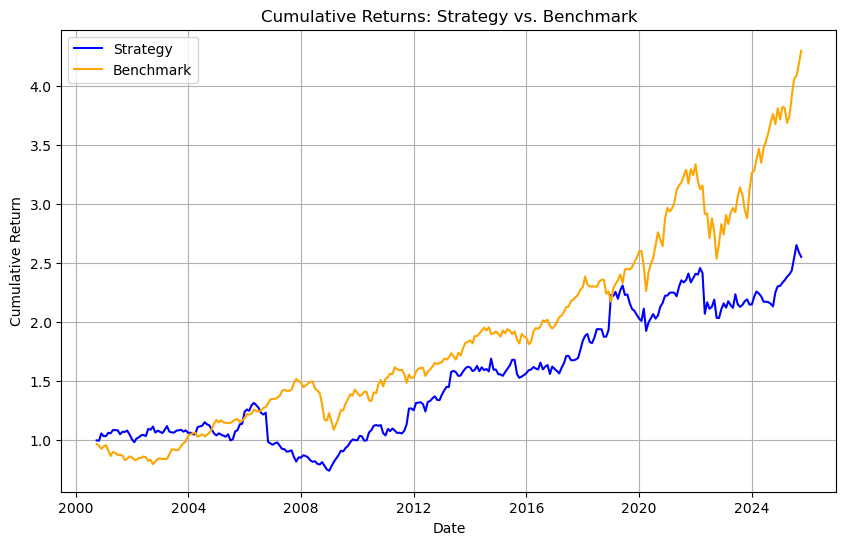

In [97]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()